# An example for using the battery degradation module

## Modify your path

In [1]:
import sys
path_to_current_folder = !pwd
path_to_project = '/'.join(path_to_current_folder[0].split('/')[:-2])
sys.path.insert(1, path_to_project)

## Import necessary functions

In [32]:
import torch
from torch import nn
from torch import optim
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from battery_degradation_prediction.preprocessing import get_clean_data
from battery_degradation_prediction.load_data import load_supervised_data
from battery_degradation_prediction.visualizing_cycle_data import plot_cycle_capacity
from battery_degradation_prediction.model import Transformer
from battery_degradation_prediction.train import train, evaluate
from battery_degradation_prediction.plot_model import (
    plot_train_val_loss,
    parity_plot,
)

## Data preprocessing

### Get clean data 
Please make sure download NASA data from [here](link_to_the_data). Then, use the matlab codes to convert the .mat files to .csv files. Move these .csv files to the data/ folder.

In [11]:
project_path = sys.path[1]
data_path = project_path + "/data/B0005.csv"
num_row = int(1e7)
df_discharge = get_clean_data(data_path, num_row)
df_discharge.head()

,voltage_measured,current_measured,temperatrue_measured,capcity_during_discharge,capacity,time,cycle
0,4.051065,-1.947373,24.407874,-0.001067,1.856487,0.000000,1
1,3.978237,-2.011462,24.375109,0.018883,1.856487,0.009391,1
2,3.938217,-2.011563,24.686277,0.037780,1.856487,0.018782,1
3,3.912101,-2.014623,25.032415,0.056762,1.856487,0.028173,1
4,3.892568,-2.014680,25.405188,0.075691,1.856487,0.037565,1


### Plot how the capacity degrades over cycles

0

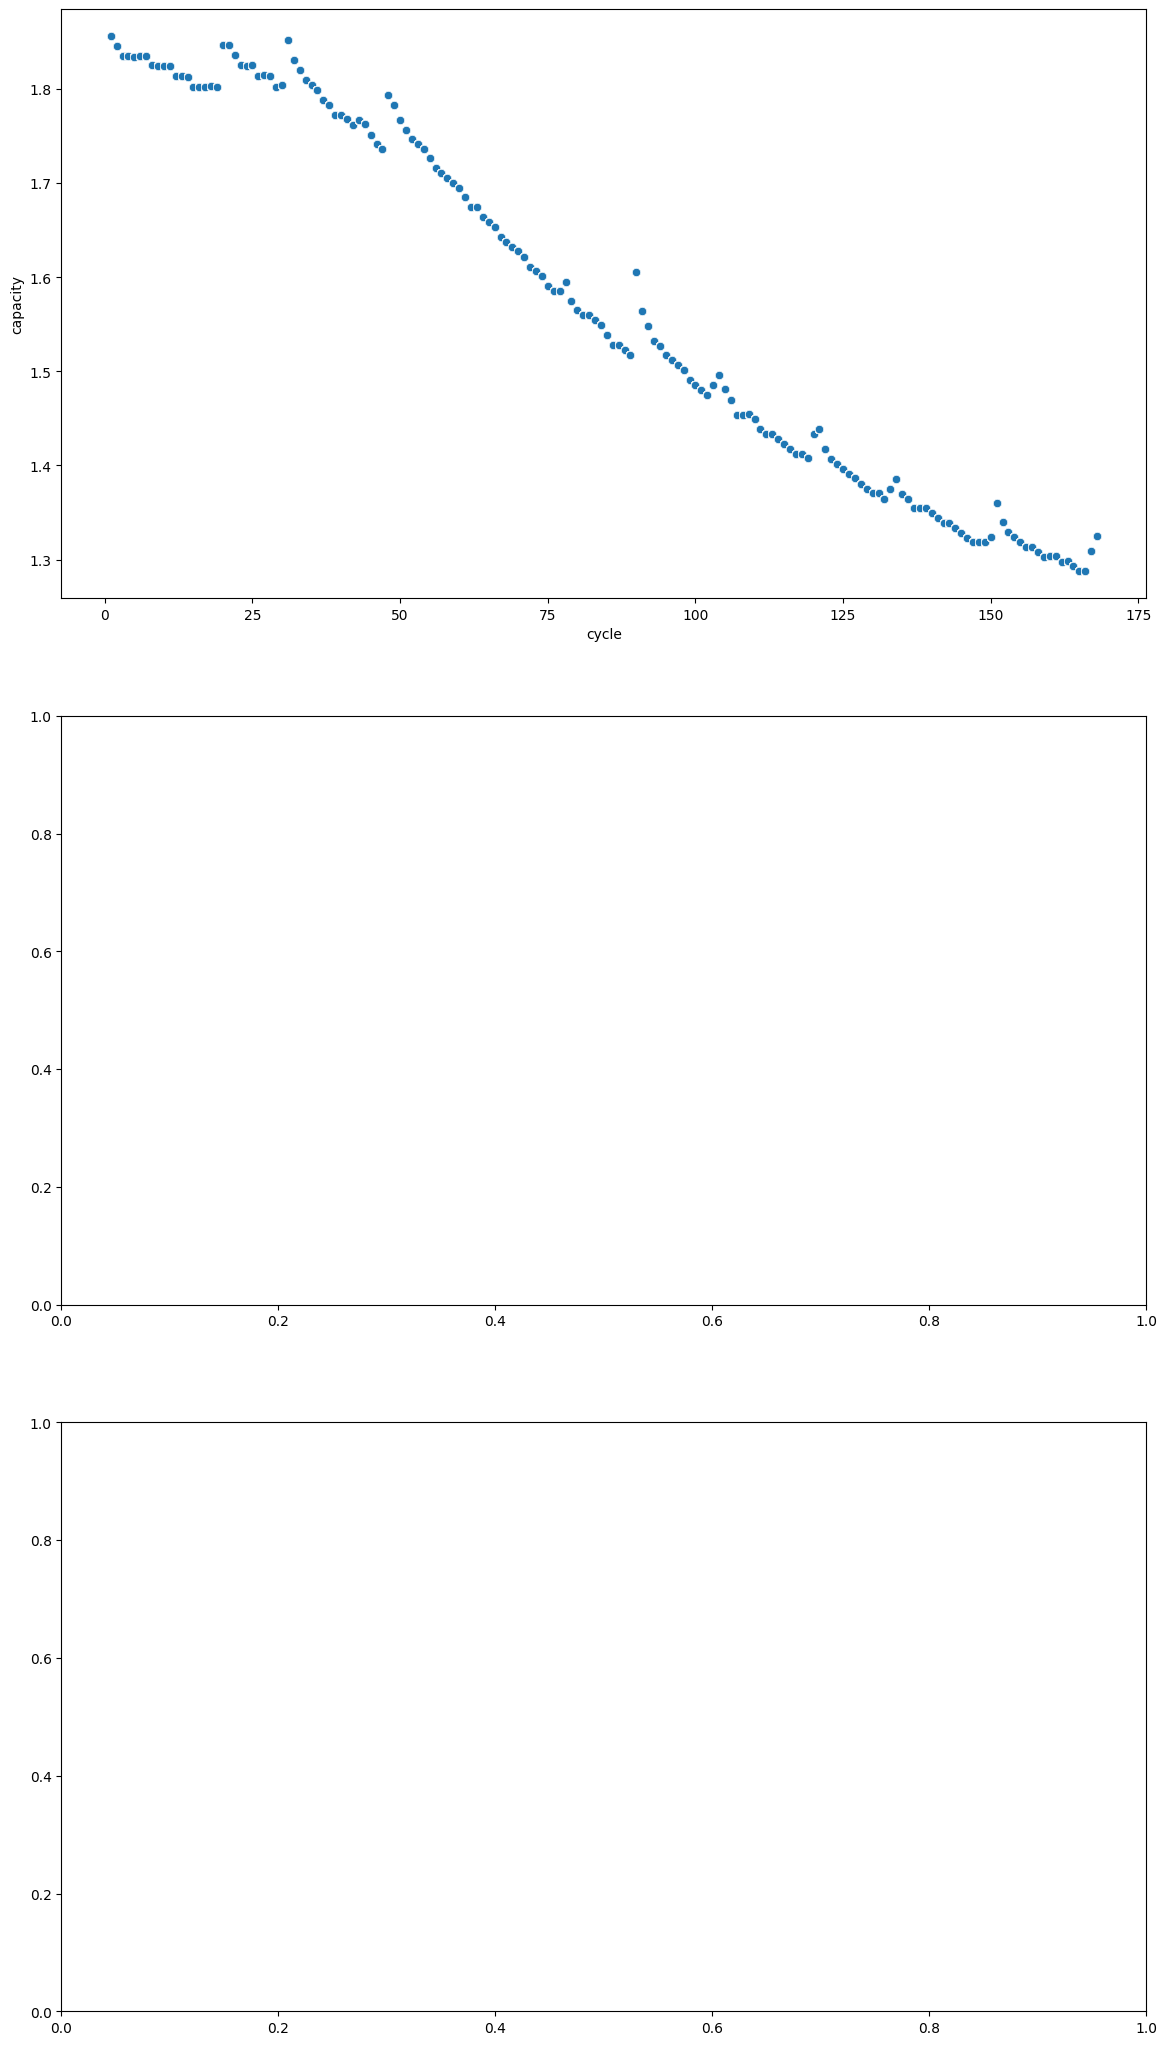

In [12]:
plot_cycle_capacity(df_discharge)

## Load data for supervised learning

We will only train our model on the following 4 features, 1) voltage_measured, 2) current_measured, 3) temperatrue_measured, and 4) capcity_during_discharge. And predict 4) capcity_during_discharge in the next step. To get more information about how we group the data, please see here:
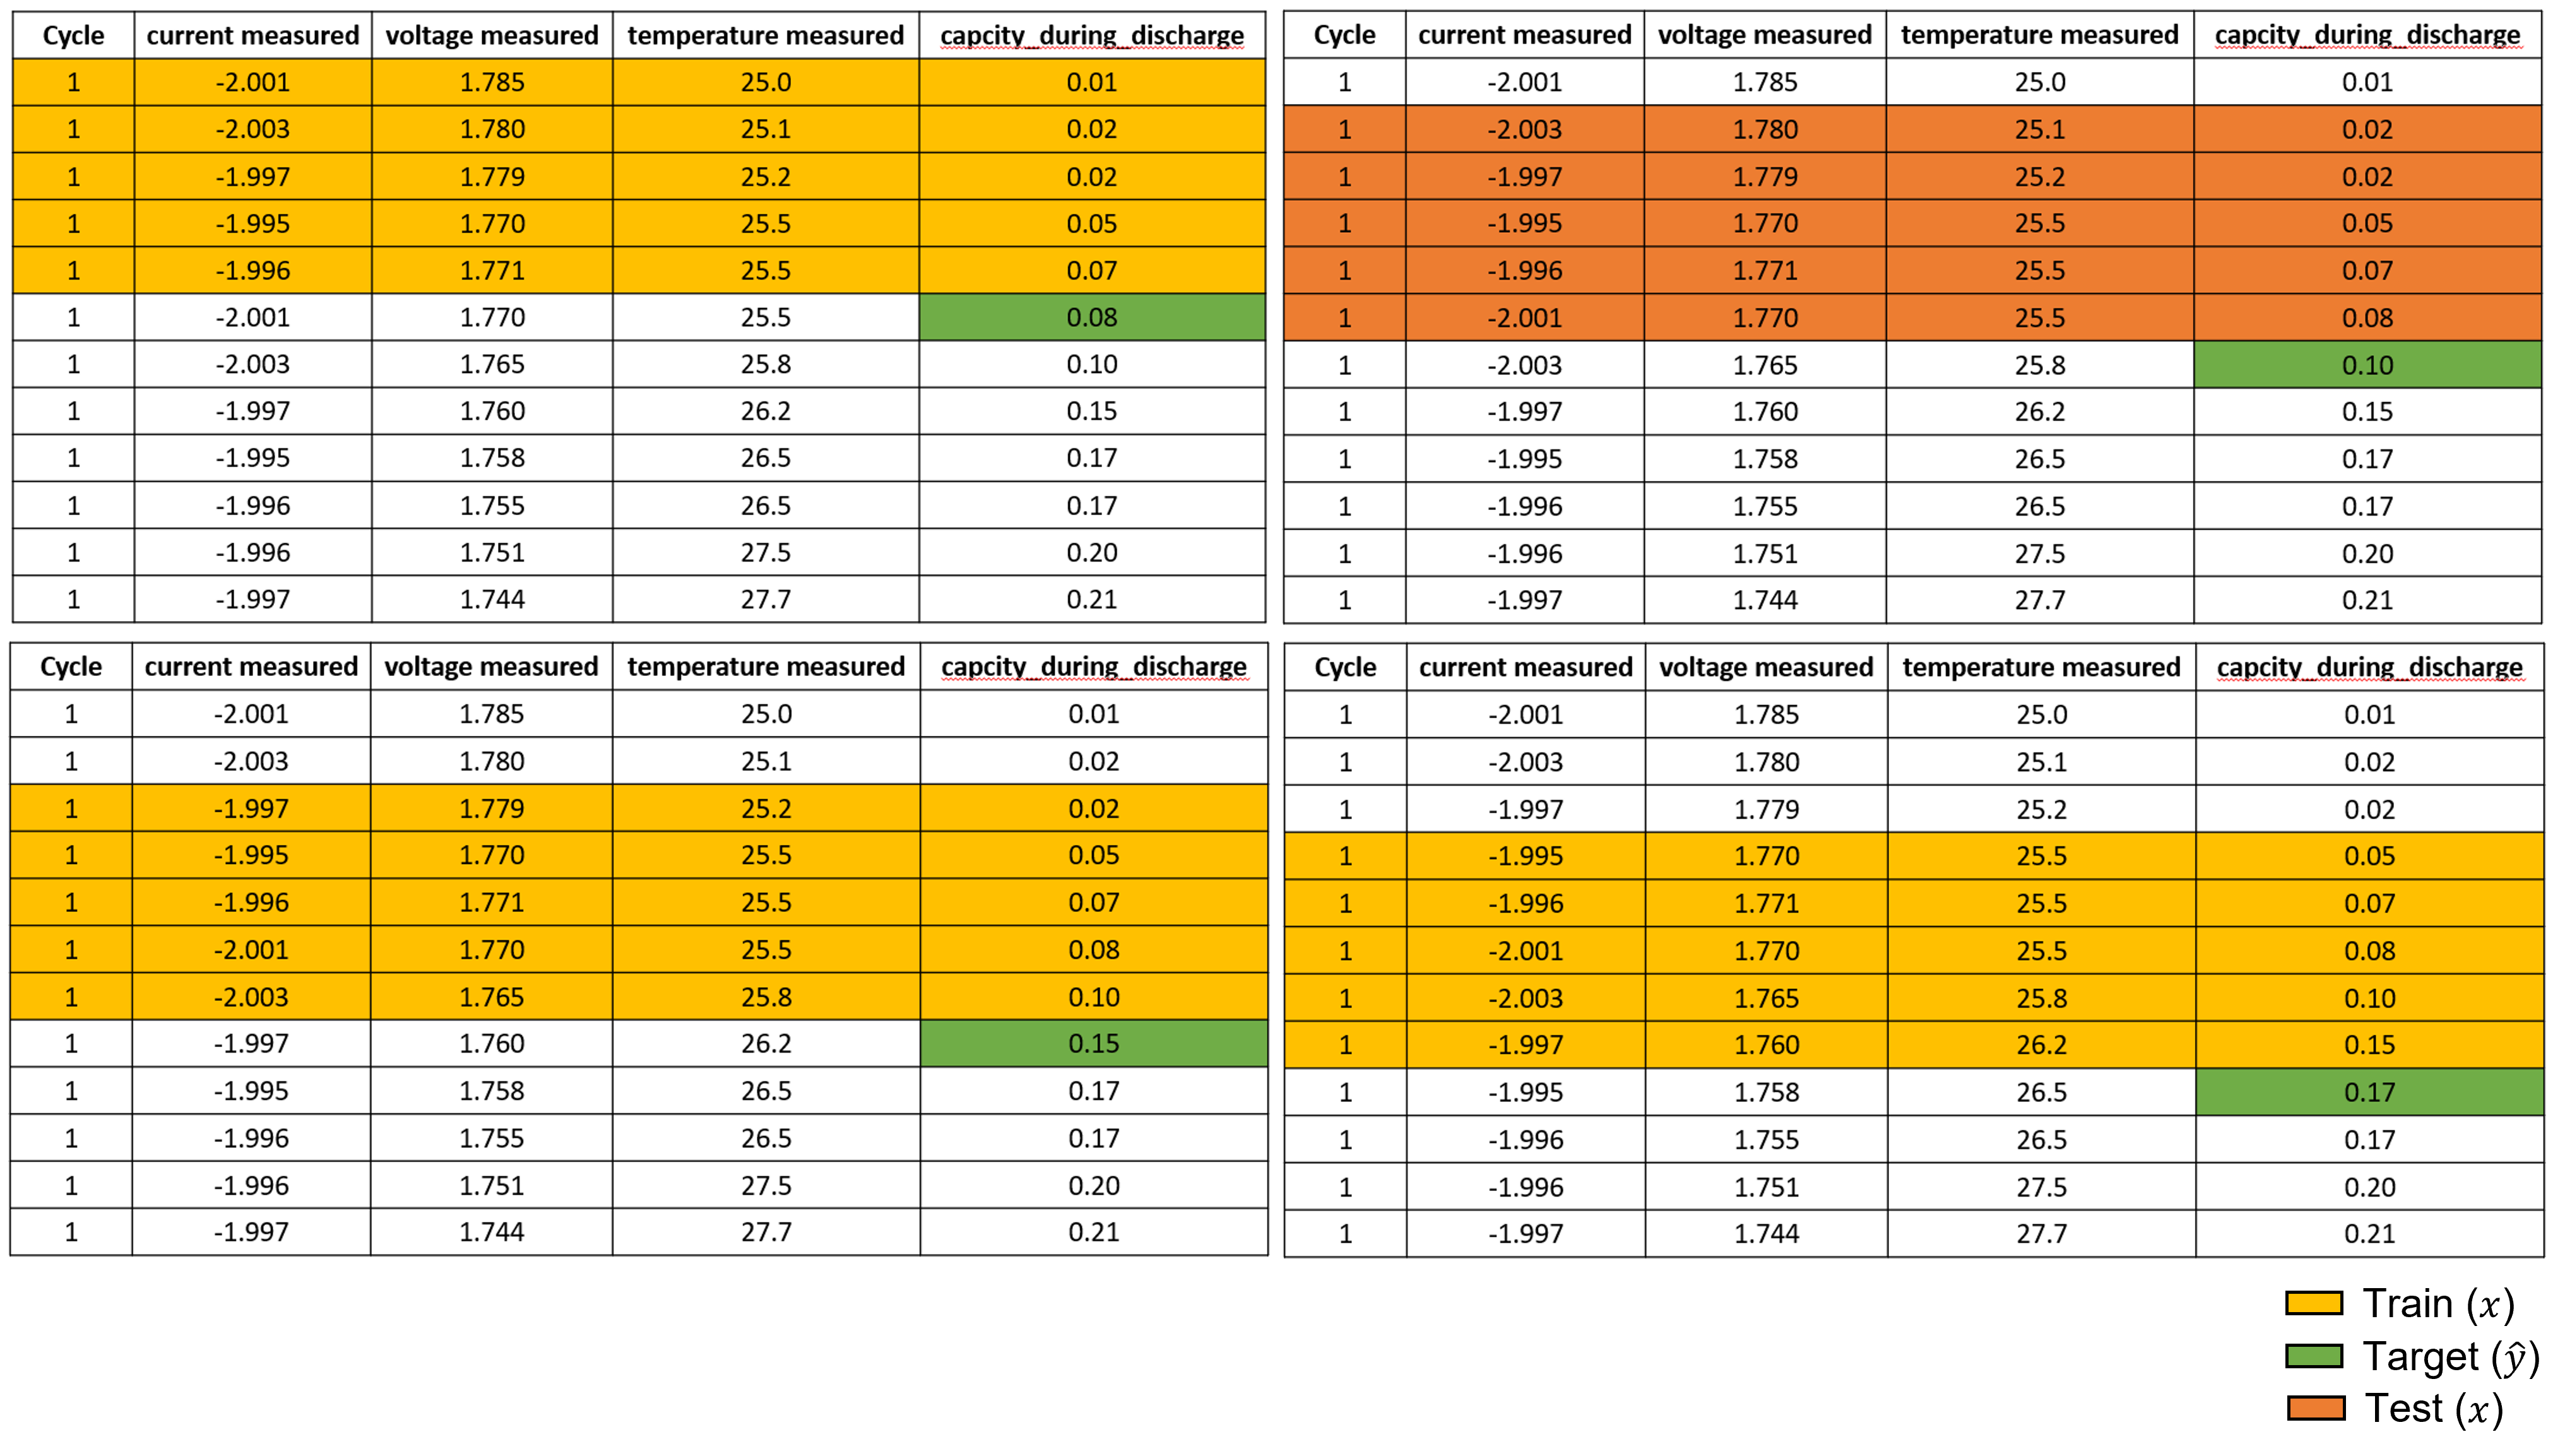

### Define test size and window size

In [13]:
test_size = 0.2
window_size = 5
feature_names = [
    "cycle",
    "voltage_measured",
    "current_measured",
    "temperatrue_measured",
    "capcity_during_discharge",
    "capacity",
]

### Load Data

In [17]:
(dev_x, dev_y), (test_x, test_y), _, y_scaler = load_supervised_data(
    df_discharge, test_size, feature_names, window_size
)
print(f"dev_x = {dev_x.shape}, dev_y = {dev_y.shape}")
print(f"test_x = {test_x.shape}, test_y = {test_y.shape}")
print("==== X ====")
print(dev_x[:3])
print("==== y ====")
print(dev_y[:3])

dev_x = (12730, 5, 4), dev_y = (12730, 1)
test_x = (3230, 5, 4), test_y = (3230, 1)
==== X ====
[[[ 2.56074322 38.87726297 -2.33904145 -1.80076663]
  [ 2.2142361   0.65447722 -2.34842599 -1.75646517]
  [ 2.02382343  0.59410942 -2.25930157 -1.71450138]
  [ 1.89956682 -1.23079334 -2.16016119 -1.67234797]
  [ 1.80663294 -1.26454302 -2.05339211 -1.6303147 ]]

 [[ 2.2142361   0.65447722 -2.34842599 -1.75646517]
  [ 2.02382343  0.59410942 -2.25930157 -1.71450138]
  [ 1.89956682 -1.23079334 -2.16016119 -1.67234797]
  [ 1.80663294 -1.26454302 -2.05339211 -1.6303147 ]
  [ 1.72900343  0.07127266 -1.95016639 -1.5885448 ]]

 [[ 2.02382343  0.59410942 -2.25930157 -1.71450138]
  [ 1.89956682 -1.23079334 -2.16016119 -1.67234797]
  [ 1.80663294 -1.26454302 -2.05339211 -1.6303147 ]
  [ 1.72900343  0.07127266 -1.95016639 -1.5885448 ]
  [ 1.6610044  -0.30490507 -1.84954197 -1.5465078 ]]]
==== y ====
[[-1.62329132]
 [-1.58128203]
 [-1.53917416]]


### Move data to cpu or cuda

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device = {device}")
dev_x = torch.from_numpy(dev_x).type(torch.float32).to(device)
dev_y = torch.from_numpy(dev_y).type(torch.float32).to(device)
test_x = torch.from_numpy(test_x).type(torch.float32).to(device)
test_y = torch.from_numpy(test_y).type(torch.float32).to(device)

device = cuda


### Define hyperparameters

In [21]:
epochs = 25
input_shape = dev_x.shape[1:]
d_model = 8
nhead = 2
num_layers = 2
output_size = 1
dropout = 0.2
batch_size = 64
num_folds = 5

### Define model

In [22]:
model = Transformer(input_shape, d_model, nhead, num_layers, output_size, dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

### Cross-validataion

In [25]:
histories = []
models = []
k_fold = KFold(n_splits=num_folds)
k_fold.get_n_splits(dev_x)
cross_val = 1
if cross_val:
    for fold, (train_index, val_index) in enumerate(k_fold.split(dev_x)):
        train_x, val_x = dev_x[train_index], dev_x[val_index]
        train_y, val_y = dev_y[train_index], dev_y[val_index]
        print(f"ʕ •ᴥ•ʔ -- Fold {fold} -- ʕ •ᴥ•ʔ")
        model, history = train(
            train_x,
            train_y,
            val_x,
            val_y,
            model,
            epochs,
            batch_size,
            optimizer,
            criterion,
        )
        models.append(model)
        histories.append(history)

ʕ •ᴥ•ʔ -- Fold 0 -- ʕ •ᴥ•ʔ
epochs =  25
 ===== Epoch: 1/25 =====
Batch 1/159 | loss = 1.22675
Batch 21/159 | loss = 0.08880
Batch 41/159 | loss = 0.05453
Batch 61/159 | loss = 0.04369
Batch 81/159 | loss = 0.05383
Batch 101/159 | loss = 0.03740
Batch 121/159 | loss = 0.03201
Batch 141/159 | loss = 0.02491
Epoch = 1 | val_loss = 0.01129
 ===== Epoch: 2/25 =====
Batch 1/159 | loss = 0.00584
Batch 21/159 | loss = 0.00424
Batch 41/159 | loss = 0.00423
Batch 61/159 | loss = 0.00166
Batch 81/159 | loss = 0.00228
Batch 101/159 | loss = 0.00150
Batch 121/159 | loss = 0.00529
Batch 141/159 | loss = 0.00189
Epoch = 2 | val_loss = 0.00282
 ===== Epoch: 3/25 =====
Batch 1/159 | loss = 0.00100
Batch 21/159 | loss = 0.00086
Batch 41/159 | loss = 0.00185
Batch 61/159 | loss = 0.00167
Batch 81/159 | loss = 0.00080
Batch 101/159 | loss = 0.00124
Batch 121/159 | loss = 0.00112
Batch 141/159 | loss = 0.00075
Epoch = 3 | val_loss = 0.00188
 ===== Epoch: 4/25 =====
Batch 1/159 | loss = 0.00104
Batch 21/159

Batch 21/159 | loss = 0.00012
Batch 41/159 | loss = 0.00019
Batch 61/159 | loss = 0.00021
Batch 81/159 | loss = 0.00016
Batch 101/159 | loss = 0.00010
Batch 121/159 | loss = 0.00007
Batch 141/159 | loss = 0.00016
Epoch = 3 | val_loss = 0.00036
 ===== Epoch: 4/25 =====
Batch 1/159 | loss = 0.00022
Batch 21/159 | loss = 0.00024
Batch 41/159 | loss = 0.00013
Batch 61/159 | loss = 0.00014
Batch 81/159 | loss = 0.00031
Batch 101/159 | loss = 0.00011
Batch 121/159 | loss = 0.00007
Batch 141/159 | loss = 0.00010
Epoch = 4 | val_loss = 0.00027
 ===== Epoch: 5/25 =====
Batch 1/159 | loss = 0.00021
Batch 21/159 | loss = 0.00009
Batch 41/159 | loss = 0.00008
Batch 61/159 | loss = 0.00005
Batch 81/159 | loss = 0.00007
Batch 101/159 | loss = 0.00007
Batch 121/159 | loss = 0.00006
Batch 141/159 | loss = 0.00006
Epoch = 5 | val_loss = 0.00026
 ===== Epoch: 6/25 =====
Batch 1/159 | loss = 0.00006
Batch 21/159 | loss = 0.00004
Batch 41/159 | loss = 0.00012
Batch 61/159 | loss = 0.00005
Batch 81/159 | l

Batch 101/159 | loss = 0.00003
Batch 121/159 | loss = 0.00004
Batch 141/159 | loss = 0.00004
Epoch = 5 | val_loss = 0.00005
 ===== Epoch: 6/25 =====
Batch 1/159 | loss = 0.00005
Batch 21/159 | loss = 0.00004
Batch 41/159 | loss = 0.00003
Batch 61/159 | loss = 0.00003
Batch 81/159 | loss = 0.00001
Batch 101/159 | loss = 0.00002
Batch 121/159 | loss = 0.00002
Batch 141/159 | loss = 0.00007
Epoch = 6 | val_loss = 0.00005
 ===== Epoch: 7/25 =====
Batch 1/159 | loss = 0.00009
Batch 21/159 | loss = 0.00003
Batch 41/159 | loss = 0.00002
Batch 61/159 | loss = 0.00001
Batch 81/159 | loss = 0.00006
Batch 101/159 | loss = 0.00003
Batch 121/159 | loss = 0.00002
Batch 141/159 | loss = 0.00002
Epoch = 7 | val_loss = 0.00003
 ===== Epoch: 8/25 =====
Batch 1/159 | loss = 0.00002
Batch 21/159 | loss = 0.00002
Batch 41/159 | loss = 0.00003
Batch 61/159 | loss = 0.00002
Batch 81/159 | loss = 0.00001
Batch 101/159 | loss = 0.00005
Batch 121/159 | loss = 0.00005
Batch 141/159 | loss = 0.00002
Epoch = 8 | v

Batch 21/159 | loss = 0.00001
Batch 41/159 | loss = 0.00002
Batch 61/159 | loss = 0.00003
Batch 81/159 | loss = 0.00001
Batch 101/159 | loss = 0.00003
Batch 121/159 | loss = 0.00001
Batch 141/159 | loss = 0.00001
Epoch = 8 | val_loss = 0.00002
 ===== Epoch: 9/25 =====
Batch 1/159 | loss = 0.00003
Batch 21/159 | loss = 0.00002
Batch 41/159 | loss = 0.00001
Batch 61/159 | loss = 0.00005
Batch 81/159 | loss = 0.00002
Batch 101/159 | loss = 0.00001
Batch 121/159 | loss = 0.00002
Batch 141/159 | loss = 0.00004
Epoch = 9 | val_loss = 0.00003
 ===== Epoch: 10/25 =====
Batch 1/159 | loss = 0.00002
Batch 21/159 | loss = 0.00001
Batch 41/159 | loss = 0.00001
Batch 61/159 | loss = 0.00001
Batch 81/159 | loss = 0.00002
Batch 101/159 | loss = 0.00007
Batch 121/159 | loss = 0.00003
Batch 141/159 | loss = 0.00005
Epoch = 10 | val_loss = 0.00001
 ===== Epoch: 11/25 =====
Batch 1/159 | loss = 0.00003
Batch 21/159 | loss = 0.00002
Batch 41/159 | loss = 0.00001
Batch 61/159 | loss = 0.00002
Batch 81/159 

Batch 101/159 | loss = 0.00001
Batch 121/159 | loss = 0.00003
Batch 141/159 | loss = 0.00001
Epoch = 10 | val_loss = 0.00001
 ===== Epoch: 11/25 =====
Batch 1/159 | loss = 0.00001
Batch 21/159 | loss = 0.00001
Batch 41/159 | loss = 0.00002
Batch 61/159 | loss = 0.00002
Batch 81/159 | loss = 0.00002
Batch 101/159 | loss = 0.00001
Batch 121/159 | loss = 0.00002
Batch 141/159 | loss = 0.00002
Epoch = 11 | val_loss = 0.00003
 ===== Epoch: 12/25 =====
Batch 1/159 | loss = 0.00002
Batch 21/159 | loss = 0.00001
Batch 41/159 | loss = 0.00001
Batch 61/159 | loss = 0.00001
Batch 81/159 | loss = 0.00001
Batch 101/159 | loss = 0.00001
Batch 121/159 | loss = 0.00001
Batch 141/159 | loss = 0.00001
Epoch = 12 | val_loss = 0.00003
 ===== Epoch: 13/25 =====
Batch 1/159 | loss = 0.00002
Batch 21/159 | loss = 0.00002
Batch 41/159 | loss = 0.00002
Batch 61/159 | loss = 0.00001
Batch 81/159 | loss = 0.00001
Batch 101/159 | loss = 0.00001
Batch 121/159 | loss = 0.00001
Batch 141/159 | loss = 0.00001
Epoch =

### Plot loss vs. epochs

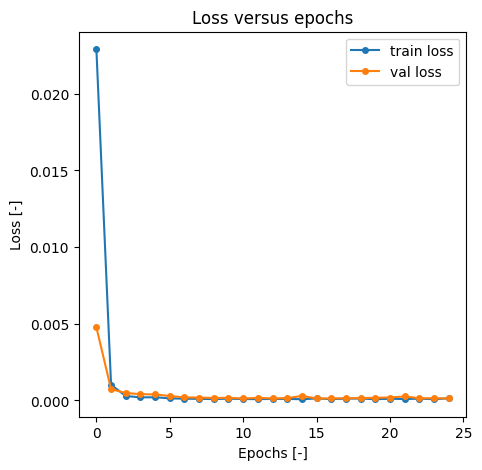

In [28]:
plot_train_val_loss(histories)

### Retrain the model using the entire dev dataset

In [29]:
model = Transformer(input_shape, d_model, nhead, num_layers, output_size, dropout).to(device)
optimizer = optim.Adam(model.parameters())
model, history = train(
    dev_x, dev_y, dev_x, dev_y, model, epochs, batch_size, optimizer, criterion
)

epochs =  25
 ===== Epoch: 1/25 =====
Batch 1/198 | loss = 0.73059
Batch 21/198 | loss = 0.09339
Batch 41/198 | loss = 0.04650
Batch 61/198 | loss = 0.04701
Batch 81/198 | loss = 0.02284
Batch 101/198 | loss = 0.03720
Batch 121/198 | loss = 0.02313
Batch 141/198 | loss = 0.01777
Batch 161/198 | loss = 0.02235
Batch 181/198 | loss = 0.02369
Epoch = 1 | val_loss = 0.00918
 ===== Epoch: 2/25 =====
Batch 1/198 | loss = 0.01276
Batch 21/198 | loss = 0.00758
Batch 41/198 | loss = 0.00223
Batch 61/198 | loss = 0.00261
Batch 81/198 | loss = 0.00071
Batch 101/198 | loss = 0.00062
Batch 121/198 | loss = 0.00054
Batch 141/198 | loss = 0.00020
Batch 161/198 | loss = 0.00044
Batch 181/198 | loss = 0.00019
Epoch = 2 | val_loss = 0.00047
 ===== Epoch: 3/25 =====
Batch 1/198 | loss = 0.00016
Batch 21/198 | loss = 0.00016
Batch 41/198 | loss = 0.00018
Batch 61/198 | loss = 0.00090
Batch 81/198 | loss = 0.00030
Batch 101/198 | loss = 0.00063
Batch 121/198 | loss = 0.00029
Batch 141/198 | loss = 0.00024


Batch 161/198 | loss = 0.00018
Batch 181/198 | loss = 0.00004
Epoch = 23 | val_loss = 0.00004
 ===== Epoch: 24/25 =====
Batch 1/198 | loss = 0.00004
Batch 21/198 | loss = 0.00005
Batch 41/198 | loss = 0.00006
Batch 61/198 | loss = 0.00004
Batch 81/198 | loss = 0.00019
Batch 101/198 | loss = 0.00005
Batch 121/198 | loss = 0.00002
Batch 141/198 | loss = 0.00006
Batch 161/198 | loss = 0.00018
Batch 181/198 | loss = 0.00021
Epoch = 24 | val_loss = 0.00011
 ===== Epoch: 25/25 =====
Batch 1/198 | loss = 0.00011
Batch 21/198 | loss = 0.00010
Batch 41/198 | loss = 0.00013
Batch 61/198 | loss = 0.00014
Batch 81/198 | loss = 0.00005
Batch 101/198 | loss = 0.00004
Batch 121/198 | loss = 0.00006
Batch 141/198 | loss = 0.00015
Batch 161/198 | loss = 0.00013
Batch 181/198 | loss = 0.00036
Epoch = 25 | val_loss = 0.00097


### Save model

In [30]:
model_path = "./supervised_model"
#torch.save(model.state_dict(), model_path)

### Evaluate the model

evaluate


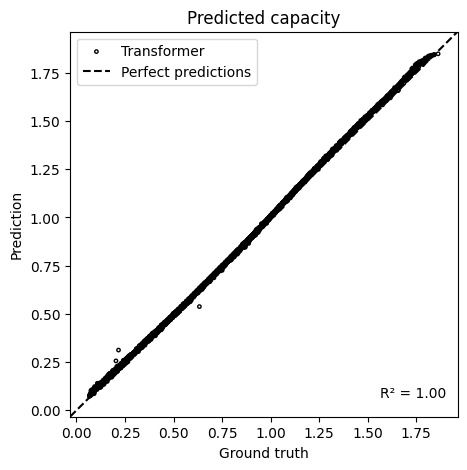

test loss = 0.0010917017934843898


In [33]:
print("evaluate")
model.eval()
test_loss = evaluate(model, test_x, test_y, criterion)
pred = model(test_x)
pred = pred.cpu().detach().numpy()
test_y = test_y.cpu().detach().numpy()
pred_inv = y_scaler.inverse_transform(pred)
test_inv = y_scaler.inverse_transform(test_y)

parity_plot(test_inv, pred_inv)
print(f"test loss = {test_loss}")